# clEsperanto
[clEsperanto](http://clesperanto.net) is a project between multiple bio-image analysis ecosystem aiming at removing language barriers. It is based on [OpenCL](https://www.khronos.org/opencl/), an open standard for programming graphics processing units (GPUs, and more) and its python wrapper [pyopencl](https://documen.tician.de/pyopencl/). Under the hood, it uses processing kernels originating from the [clij](https://clij.github.io) project.

See also
* [GPU-accelerated image analysis in Fiji and Napari, EuroBioimaging Virtual Pub](https://www.youtube.com/watch?v=MERVnf5_QkI)
* [pyclesperanto-prototype](https://github.com/clEsperanto/pyclesperanto_prototype)
* [pyclesperanto API](https://clij.github.io/clij2-docs/reference__pyclesperanto)
* [Napari pyclesperanto Assistant](https://clesperanto.github.io/napari_pyclesperanto_assistant/)

## GPU Initialization
We'll start with initializing checking out what GPUs are installed:

In [1]:
import pyclesperanto_prototype as cle

# list available devices
cle.available_device_names()

['Intel(R) UHD Graphics 620']

In [2]:
# select a specific device with only a part of its name
cle.select_device("2080")

<Intel(R) UHD Graphics 620 on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

In [3]:
# check which device is uses right now
cle.get_device()

<Intel(R) UHD Graphics 620 on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

## Processing images
For loading image data, we use scikit-image as usual:

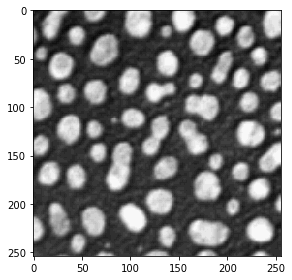

In [4]:
from skimage.io import imread, imshow

image = imread("blobs.tif")
imshow(image)

The `cle.` gateway has all methods you need, there are not sub-packages:

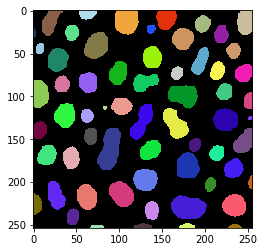

In [5]:
# noise removal
blurred = cle.gaussian_blur(image, sigma_x=1, sigma_y=1)

# binarization
binary = cle.threshold_otsu(blurred)

# labeling
labels = cle.connected_components_labeling_box(binary)

# visualize results
cle.imshow(labels, labels=True)

## Categories of operations
You could of course just reat the documentation of these methods, e.g. [Gaussian blur](https://clij.github.io/clij2-docs/reference_gaussianBlur2D).

However, you can also navigate through `cle` by asking it to list operations. E.g. for noise removal, segmentation or labeling:

In [6]:
cle.operations('denoise').keys()

dict_keys(['gaussian_blur', 'mean_box', 'mean_sphere'])

In [7]:
cle.operations('background removal').keys()

dict_keys(['bottom_hat_box', 'bottom_hat_sphere', 'difference_of_gaussian', 'divide_by_gaussian_background', 'subtract_gaussian_background', 'top_hat_box', 'top_hat_sphere'])

In [8]:
cle.operations('binarize').keys()

dict_keys(['detect_label_edges', 'detect_maxima_box', 'detect_minima_box', 'equal', 'equal_constant', 'greater', 'greater_constant', 'greater_or_equal', 'greater_or_equal_constant', 'label_to_mask', 'local_threshold', 'not_equal', 'not_equal_constant', 'smaller', 'smaller_constant', 'smaller_or_equal', 'smaller_or_equal_constant', 'threshold', 'threshold_otsu'])

In [9]:
cle.operations('label').keys()

dict_keys(['connected_components_labeling_box', 'connected_components_labeling_diamond', 'label_spots', 'masked_voronoi_labeling', 'voronoi_labeling', 'voronoi_otsu_labeling'])

Some of these operations, e.g. [voronoi_otsu_labeling](https://nbviewer.jupyter.org/github/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb) are in fact short-cuts and combine a number of operations such as Gaussian blur, Voronoi-labeling and Otsu-thresholding to go from a raw image to a label image directly:

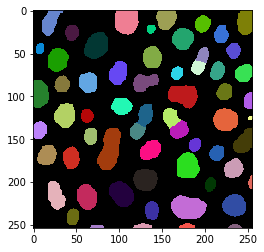

In [10]:
labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5, outline_sigma=1)

cle.imshow(labels, labels=True)

Also, just a reminder, read the documentation of methods you haven't used before:

In [11]:
print(cle.voronoi_otsu_labeling.__doc__)

Applies two Gaussian blurs, spot detection, Otsu-thresholding and Voronoi-labeling.

    The thresholded binary image is flooded using the Voronoi approach starting from the found local maxima.
    Noise-removal sigma for spot detection and thresholding can be configured separately.
    
    Parameters
    ----------
    source : Image
    label_image_destination : Image
    spot_sigma : float

    outline_sigma : float

    
    Returns
    -------
    label_image_destination
    
    Examples
    --------
    >>> import pyclesperanto_prototype as cle
    >>> cle.voronoi_otsu_labeling(source, label_image_destination, 10, 2)
    
    References
    ----------
    .. [1] https://clij.github.io/clij2-docs/reference_voronoiOtsuLabeling
    


You can also list the available categories:

In [12]:
cle.categories()

['filter',
 'in assistant',
 'combine',
 'label measurement',
 'binary processing',
 'background removal',
 'transform',
 'label',
 'binarize',
 'mesh',
 'label processing',
 'denoise',
 'edge detection',
 'map',
 'neighbor',
 'projection']

## Interoperability 
In pyclesperanto, images are handled in the random access memory (RAM) of your GPU. If you want to use other libraries, which process images on the GPU, the memory must be transferred back. Usually, this happens transparently for the user, e.g. when using scikit-image for measuring region properties:

In [13]:
from skimage.measure import regionprops

statistics = regionprops(labels)

import numpy as np
np.mean([s.area for s in statistics])

3.2131147

If you want to explicitly convert your image, e.g. into a numpy array, you can do it like this:

In [14]:
np.asarray(labels)

array([[ 0,  0,  0, ..., 57, 57, 57],
       [ 0,  0,  0, ..., 57, 57, 57],
       [ 0,  0,  0, ..., 57, 57, 57],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)

## Memory management
In jupyter noteboooks, variables are kept alive as long as the notebook kernel is running. Thus, your GPU may fill up with memory. Thus, if you don't need an image anymore, set it to `None`. It will then be remove from GPU memory thanks to [pyopencl](https://documen.tician.de/pyopencl/) magic.

In [15]:
image = None
blurred = None
binary = None
labels = None

## Napari integration
There is nothing special when using clEsperanto and napari together from jupyter notebooks.

In [16]:
import napari

# start viewer
viewer = napari.Viewer(ndisplay=3)

# load image
from skimage.io import imread
image = imread("Lund_000500_resampled-cropped.tif")

viewer.add_image(image)

<Image layer 'image' at 0x1eedaaf6400>

In [17]:
import pyclesperanto_prototype as cle

background_subtracted = cle.top_hat_box(image, radius_x=5, radius_y=5, radius_z=5)

labels = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=2, outline_sigma=2)

viewer.add_labels(labels)

<Labels layer 'labels' at 0x1eed14d19d0>

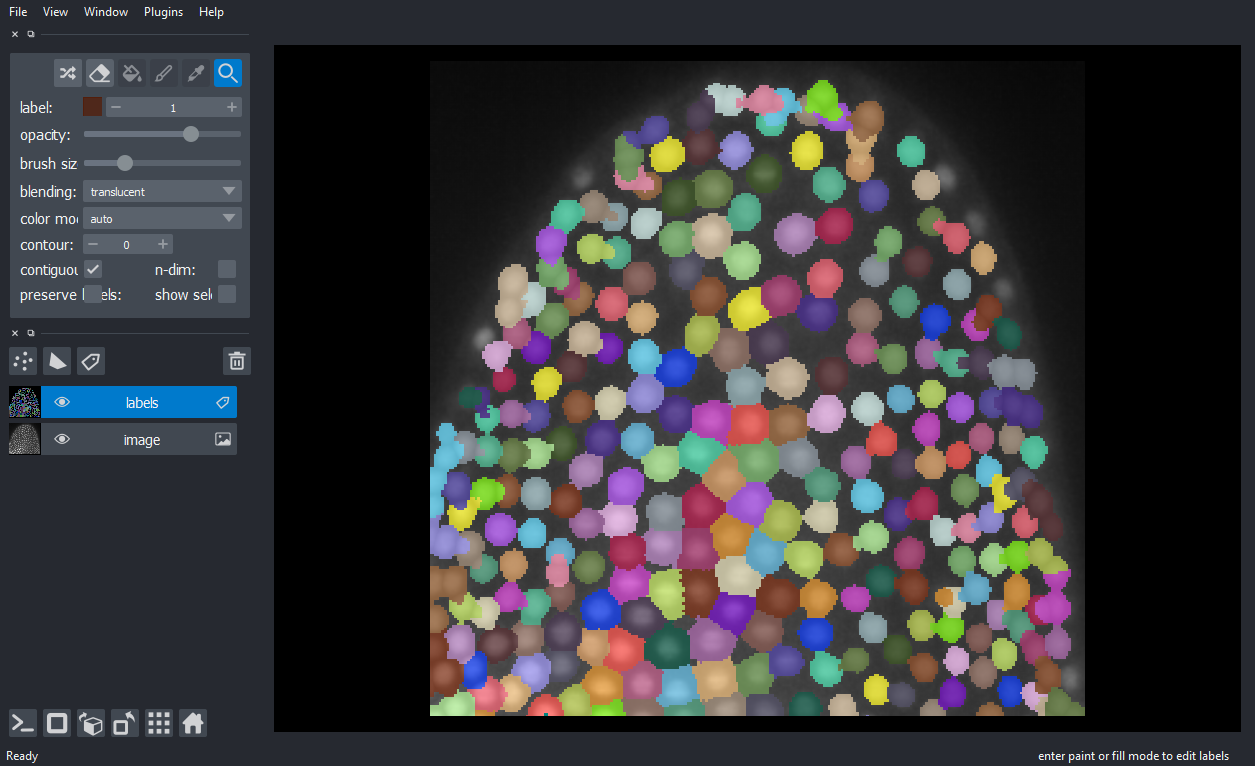

In [18]:
napari.utils.nbscreenshot(viewer)

## Support & feedback
Feedback is very welcome. In case you need support, please open a thread on [image.sc](https://image.s) . Use the tags [#clEsperanto](https://image.sc/tags/clesperanto) and [@haesleinhuepf](https://github.com/haesleinhuepf/)